In [1]:
using DifferentialEquations
using Plots, PlotThemes, LinearAlgebra, LaTeXStrings
theme(:dao)

In [2]:
struct CRMParams
    c::Matrix{Float64}
    e::Matrix{Float64}
    K::Vector{Float64}
    m::Vector{Float64}
    S::Int64
    M::Int64
    CRMParams(c,e,K,m) = size(c,1)==size(m,1) && size(c,2)==size(K,1) && size(c) == size(e) ? new(c,e,K,m,size(m)[1],size(K)[1]) : error("wrong dimensions")
end

function CRM!(du,u,p,t)
    λ = @view u[1:p.S]
    dλ = @view du[1:p.S]
    R = @view u[end+1-p.M:end]
    dR = @view du[end+1-p.M:end]
    dλ .= λ .* (p.c * R .- p.m)
    dR .= R .* (p.K .- R .-  p.e' * λ)
end

CRM! (generic function with 1 method)

In [3]:
M = 200;
S = 200;
# μc = 1e0;
# μX = 1e0;
# σc = 2e-1;
# σX = 2e-1;
μc = 1e0M;
μX = 1e0M;
σc = 2e-1sqrt(M);
σX = 2e-1sqrt(M);
K = 1e0;
σK = 1e-1;
m = 1e0;
σm = 1e-1;

In [84]:
using BenchmarkTools

K0 = K .+ σK*randn(M);
a=0.77
params = (μc/M .+ (σc/sqrt(M))*randn(M,S)) |> c -> CRMParams(c,(1.0-a)*c .+ a*(μX/M .+ (σX/sqrt(M))*randn(M,S)),K0,m .+ σm*randn(S))

function runATest()
    duTest = rand(400);
    uTest = rand(400);
    CRM!(duTest,uTest,params,0);
end
@benchmark runATest() #is faster if we use @view macro

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  20.844 μs … 831.412 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     24.128 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   24.165 μs ±   8.177 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                         ▂▄▇██▅▃▁                               
  ▂▃▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▂▂▂▃▇████████▇▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▃▂▂▂▂ ▃
  20.8 μs         Histogram: frequency by time         28.1 μs <

 Memory estimate: 10.08 KiB, allocs estimate: 5.

In [4]:
K0 = K .+ σK*randn(M);
u0=vcat(1e-1ones(S)/S,K0)
a=0.75
params = (μc/M .+ (σc/sqrt(M))*randn(M,S)) |> c -> CRMParams(c,(1.0-a)*c .+ a*(μX/M .+ (σX/sqrt(M))*randn(M,S)),K0,m .+ σm*randn(S))

tspan=(0.0,2400.0);
prob = ODEProblem(CRM!,u0,tspan,params);
sol = solve(prob,abstol=1e-14,reltol=1e-14,saveat=5);

In [11]:
[sol(2000:2400,X).u for X in [Val{0}, Val{1}]]

2-element Vector{Vector{Vector{Float64}}}:
 [[6.445753037409395e-215, 1.401437222382615e-82, -2.0e-323, 9.693044104159943e-182, 5.779946044254385e-189, 1.407005035978468e-190, 5.0e-324, 5.578240895584031e-146, 1.4949623324873544e-285, 2.2544091859458958e-300  …  2.310825498754034e-100, 5.668398558671932e-301, 1.8998008443675532e-175, 4.547324757586414e-138, -5.0e-324, 6.459273395512284e-295, 4.486610311763286e-295, 9.932032796579134e-277, 2.970761590295219e-299, 5.0e-324], [5.57096819899377e-215, 1.3282890024570536e-82, -2.0e-323, 8.483945604725925e-182, 5.006076497476713e-189, 1.2232728515843116e-190, 5.0e-324, 4.941684458401241e-146, 1.2617539604194146e-285, 1.88397284160354e-300  …  2.100990854977804e-100, 4.732812744150837e-301, 1.6294165857720596e-175, 4.024856359590792e-138, -5.0e-324, 5.3685672655870935e-295, 3.7253676947900878e-295, 8.407933861216067e-277, 2.481960709624254e-299, 5.0e-324], [4.696183360578147e-215, 1.2551407825314924e-82, -2.0e-323, 7.274847105291906e-182, 4.23

In [9]:
pλ = plot(sol,vars=(1:S),ylim=(0,:auto),label=:none,ylabel=L"\lambda_i")
pR = plot(sol,vars=((S + 1):(M+S)),ylim=(0,:auto),label=:none,ylabel=L"R_\alpha")
l = @layout([a;b])
plot(pλ,pR,layout=l)
# savefig("good-example-increasing-oscs-after-somestability.pdf")

In [6]:
function getASol(a)
    params = (μc/M .+ (σc/sqrt(M))*randn(M,S)) |> c -> CRMParams(c,(1.0-a)*c .+ a*(μX/M .+ (σX/sqrt(M))*randn(M,S)),K0,m .+ σm*randn(S))
    tspan=(0.0,2400.0);
    prob = ODEProblem(CRM!,u0,tspan,params);
    sol = solve(prob,abstol=1e-14,reltol=1e-14,saveat=4);
    return sol
end

getASol (generic function with 1 method)

In [110]:
@benchmark getASol(0.78) seconds=100

BenchmarkTools.Trial: 27 samples with 1 evaluation.
 Range (min … max):  1.259 s … 8.092 s  ┊ GC (min … max): 2.44% … 0.90%
 Time  (median):     3.716 s            ┊ GC (median):    0.83%
 Time  (mean ± σ):   3.869 s ± 2.103 s  ┊ GC (mean ± σ):  0.82% ± 0.61%

    ▁▁      ▄               █                           ▁  
  ▆▆██▁▁▆▆▁▆█▆▁▁▁▁▁▁▁▆▁▁▁▁▁▁█▆▆▁▁▆▁▁▁▆▆▁▁▁▆▁▁▁▁▁▁▁▁▁▁▆▁▁█ ▁
  1.26 s        Histogram: frequency by time       8.09 s <

 Memory estimate: 99.43 MiB, allocs estimate: 55499.

In [ ]:
using JLD2

In [ ]:
# for a in 0:0.025:1
# for a in 0.725:0.025:1
let a = 1
    GC.gc()
    @time jldsave("brief-experiment-v2_a="*string(a)*".jld2";dat=[getASol(a) for _ in 1:200])
end

In [ ]:
@time datwrta = (a -> [getASol(a) for _ in 1:100]).(0:0.025:1);

In [31]:
# using JLD2

# jldsave("brief-experiment.jld2";datwrta)
jldopen("brief-experimenta=0.0.jld2")["dat"][1](1600:2:2000,Val{1}).u[end]

400-element Vector{Float64}:
 -1.07128552111494e-249
 -2.6447981624609846e-130
 -3.344793476398871e-157
 -2.8046954754615995e-155
 -3.447871544520753e-8
 -4.614042847963804e-261
 -1.1411860192415853e-197
 -1.5034385977286278e-68
 -2.6962692925966858e-238
 -4.903644334975364e-249
  0.0
 -7.308939384518398e-225
 -8.31363171546597e-209
  ⋮
 -2.223408242437186e-218
 -2.7232630228998922e-173
 -6.5411595894156095e-167
 -8.371681383924047e-104
  0.0
  0.0
 -5.608604805062049e-187
 -2.4409083225880594e-114
  9.24146230034395e-7
 -9.197072628162883e-7
 -1.520267680428984e-198
 -1.2175010245004164e-191

In [13]:
using Statistics

In [3]:
function resIGuess(a)
#     resFora = jldopen("brief-experiment_a="*string(a)*".jld2")["dat"]#Z[1](1600:2:2000,Val{1}).u
    resFora = jldopen("brief-experiment-v2_a="*string(a)*".jld2")["dat"]#Z[1](1600:2:2000,Val{1}).u
    return (Y -> mean(mean.((X->abs.(X)).(Y(1600:2:2000,Val{1}).u)))).(resFora)
end

resIGuess (generic function with 1 method)

In [4]:
someresults = [resIGuess(a) for a in 0:0.025:1]

LoadError: UndefVarError: jldopen not defined

In [20]:
using Plots, PlotThemes; theme(:dao)

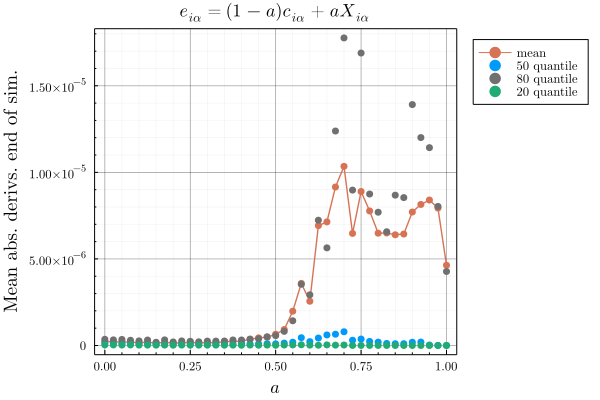

In [66]:
plot(0:0.025:1,someresults .|> X -> mean(X),label="mean",marker=:circle)
scatter!(0:0.025:1,someresults .|> X -> quantile(X,0.5),label="50 quantile")
# scatter!(0:0.025:1,meowmeow .|> X -> quantile(X,0.1),label="10 quantile")
# scatter!(0:0.025:1,meowmeow .|> X -> quantile(X,0.9),label="90 quantile")
scatter!(0:0.025:1,someresults .|> X -> quantile(X,0.8),label="80 quantile")
scatter!(0:0.025:1,someresults .|> X -> quantile(X,0.2),label="20 quantile")
plot!(xlabel=L"a",ylabel="Mean abs. derivs. end of sim.",title=L"e_{i\alpha} = (1-a)c_{i\alpha} + a X_{i\alpha}")
# scatter!(0:0.025:1,meowmeow .|> X -> maximum(X),label="max")
# savefig("temp-mean-maybe-even-better.svg")


In [23]:
function resIGuess2(a)
#     resFora = jldopen("brief-experiment_a="*string(a)*".jld2")["dat"]#Z[1](1600:2:2000,Val{1}).u
    resFora = jldopen("brief-experiment-v2_a="*string(a)*".jld2")["dat"]#Z[1](1600:2:2000,Val{1}).u
    return (Y -> mean(std.((X->abs.(X)).(Y(1600:2:2000,Val{1}).u)))).(resFora)
end

resIGuess2 (generic function with 1 method)

In [24]:
meowmeow2 = [resIGuess2(a) for a in 0:0.025:1]

41-element Vector{Vector{Float64}}:
 [6.556831410113576e-8, 1.0137422648332286e-6, 5.775199535104563e-7, 3.134072789654536e-6, 1.698182520147923e-7, 6.866286734533046e-7, 3.538466014238427e-6, 2.2443863985296123e-7, 3.442896562038733e-7, 2.148779819995096e-6  …  7.215674634102834e-7, 5.8179755035793e-7, 1.2003429921847964e-6, 4.6212871475248554e-8, 1.0319392894164884e-6, 1.1515790892499704e-6, 1.7471208927305988e-7, 8.765462468458298e-7, 4.2829466484174107e-7, 2.3357200617022593e-8]
 [4.287305608337948e-6, 8.384512746977973e-7, 6.603847450001843e-7, 1.6778453032051732e-6, 1.303806202321834e-8, 8.163343241720131e-6, 2.5794497785462674e-6, 1.2541801288296963e-7, 1.18385028570801e-6, 1.7889271320169691e-6  …  2.502773750988296e-7, 1.048437690127909e-7, 5.188444044044641e-7, 2.2559352357616353e-7, 8.193647835810661e-7, 4.778738412551807e-7, 4.4973929956299956e-7, 3.461039173695991e-7, 2.2941953843461455e-7, 1.5183486104307259e-6]
 [6.648616755866377e-7, 5.926672772094598e-7, 5.493311906656

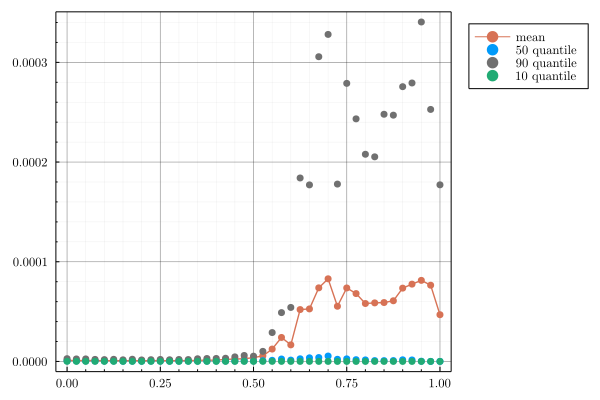

In [40]:
plot(0:0.025:1,meowmeow2 .|> X -> mean(X),label="mean",marker=:circle)
scatter!(0:0.025:1,meowmeow2 .|> X -> quantile(X,0.5),label="50 quantile")
scatter!(0:0.025:1,meowmeow2 .|> X -> quantile(X,0.9),label="90 quantile")
scatter!(0:0.025:1,meowmeow2 .|> X -> quantile(X,0.1),label="10 quantile")
# scatter!(0:0.025:1,meowmeow2 .|> X -> maximum(X),label="max")
# savefig("temp-std-w-max.pdf")


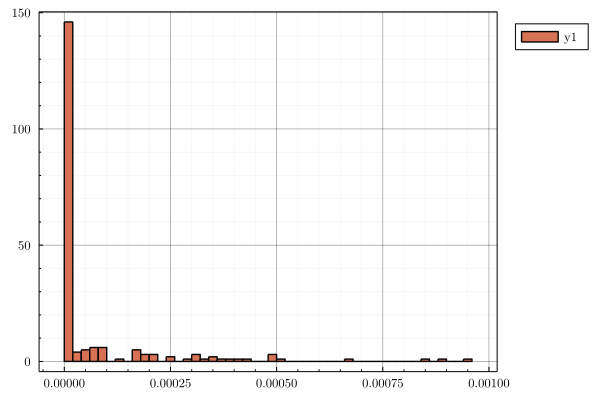

In [26]:
histogram(meowmeow2[0:0.025:1 .== 0.775][1],
#     xlim=(0,0.002)
)


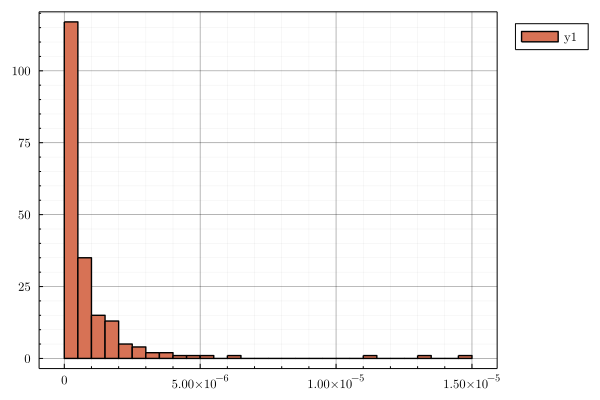

In [27]:
histogram(meowmeow2[0:0.025:1 .== 0.25][1],
#     xlim=(0,0.002)
)

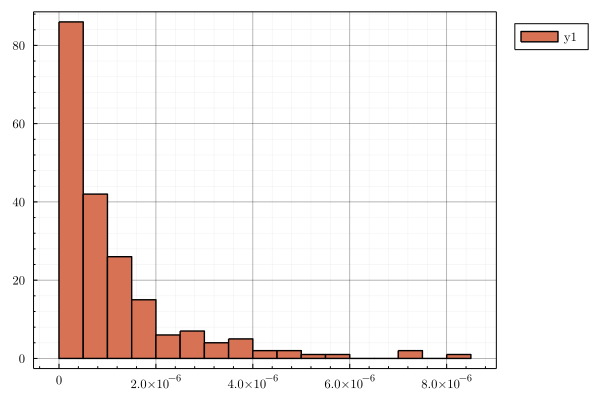

In [28]:
histogram(meowmeow2[0:0.025:1 .== 0.0][1])